In [ ]:
%pip install fiona==1.9.4.post1

In [ ]:
import os

import numpy as np

import pandas as pd
import geopandas as gpd
from shapely import Point
from shapely.geometry import LineString
from shapely import frechet_distance

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dask

from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

In [ ]:
gdf = gpd.read_file("labeled_trajectories-all.geoJSON")
zones = gpd.read_file("lanes_and_int.geojson")

In [ ]:
train_gdf, test_gdf = train_test_split(gdf, test_size=0.9, random_state=42)

In [ ]:
# Define the function to calculate the Frechet distance between two linestrings
def dh_linestring(line1, line2):
    distance = frechet_distance(line1, line2)
    return distance

# Create delayed function for computing distance matrix
@dask.delayed
def compute_distance_matrix(trajectories):
    n = len(trajectories)
    D = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist = dh_linestring(trajectories[i], trajectories[j])
            D[i][j] = dist
            D[j][i] = dist
        print(f'traj {i} out of {n} done')
    return D

In [ ]:
trajectories = list(train_gdf['geometry'])

# Create delayed task for computing distance matrix
distance_matrix = compute_distance_matrix(trajectories)

In [ ]:
gdf1 = gpd.read_file("all-interpolated.geoJSON")
train_gdf1, test_gdf1 = train_test_split(gdf1, test_size=0.5, random_state=42)
trajectories1 = list(gdf1['geometry'])

# Create delayed task for computing distance matrix
distance_matrix1 = compute_distance_matrix(trajectories1)
D = distance_matrix1.compute()


traj 0 out of 2234 done
traj 1 out of 2234 done
traj 2 out of 2234 done
traj 3 out of 2234 done
traj 4 out of 2234 done
traj 5 out of 2234 done
traj 6 out of 2234 done
traj 7 out of 2234 done
traj 8 out of 2234 done
traj 9 out of 2234 done
traj 10 out of 2234 done
traj 11 out of 2234 done
traj 12 out of 2234 done
traj 13 out of 2234 done
traj 14 out of 2234 done
traj 15 out of 2234 done
traj 16 out of 2234 done
traj 17 out of 2234 done
traj 18 out of 2234 done
traj 19 out of 2234 done
traj 20 out of 2234 done
traj 21 out of 2234 done
traj 22 out of 2234 done
traj 23 out of 2234 done
traj 24 out of 2234 done
traj 25 out of 2234 done
traj 26 out of 2234 done
traj 27 out of 2234 done
traj 28 out of 2234 done
traj 29 out of 2234 done
traj 30 out of 2234 done
traj 31 out of 2234 done
traj 32 out of 2234 done
traj 33 out of 2234 done
traj 34 out of 2234 done
traj 35 out of 2234 done
traj 36 out of 2234 done
traj 37 out of 2234 done
traj 38 out of 2234 done
traj 39 out of 2234 done
traj 40 ou

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import csv

# with open("/content/gdrive/My Drive/frechet_dist_matrix.csv", "w") as f:
#     wr = csv.writer(f)
#     wr.writerows(D)

In [ ]:
eps_values = np.arange(100, 210, 10)  # 10 values between 100 and 200
min_samples_values = np.arange(5, 16)  # 10 values between 5 and 15

# Create a 2D array to store the cluster numbers
cluster_numbers = np.zeros((len(eps_values), len(min_samples_values)), dtype=int)
noise = np.zeros((len(eps_values), len(min_samples_values)), dtype=int)


for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        mdl = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_lst = mdl.fit_predict(D)
        num_clusters = len(set(cluster_lst))
        cluster_numbers[i, j] = num_clusters
        noise[i, j] = np.sum(cluster_lst == -1)

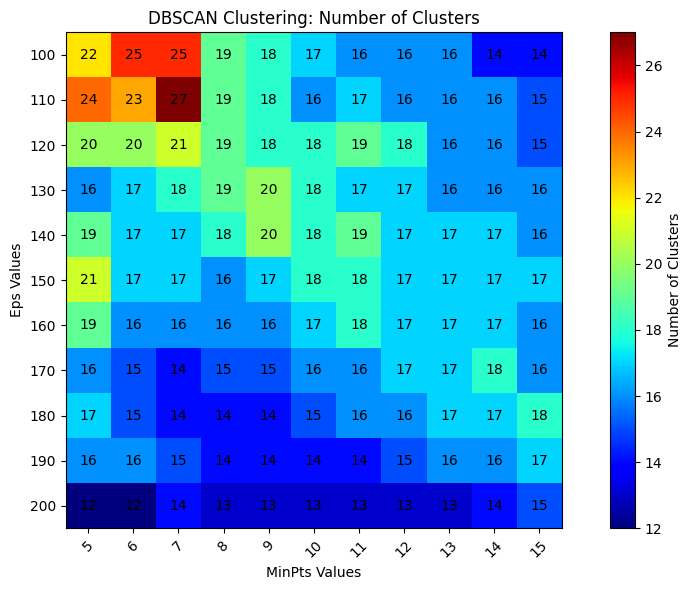

In [ ]:
y_ticks = eps_values
x_ticks = min_samples_values

# Create a heatmap of cluster numbers
plt.figure(figsize=(10, 6))
plt.imshow(cluster_numbers,cmap=plt.cm.jet)
plt.colorbar(label='Number of Clusters')
plt.ylabel('Eps Values')
plt.xlabel('MinPts Values')
plt.xticks(np.arange(len(x_ticks)), x_ticks, rotation=45)
plt.yticks(np.arange(len(y_ticks)), y_ticks)
plt.title('DBSCAN Clustering: Number of Clusters')

for i in range(len(y_ticks)):
    for j in range(len(x_ticks)):
        plt.text(j, i, str(cluster_numbers[i, j]), ha='center', va='center', color='black')

plt.grid(False)
plt.tight_layout()
plt.show()

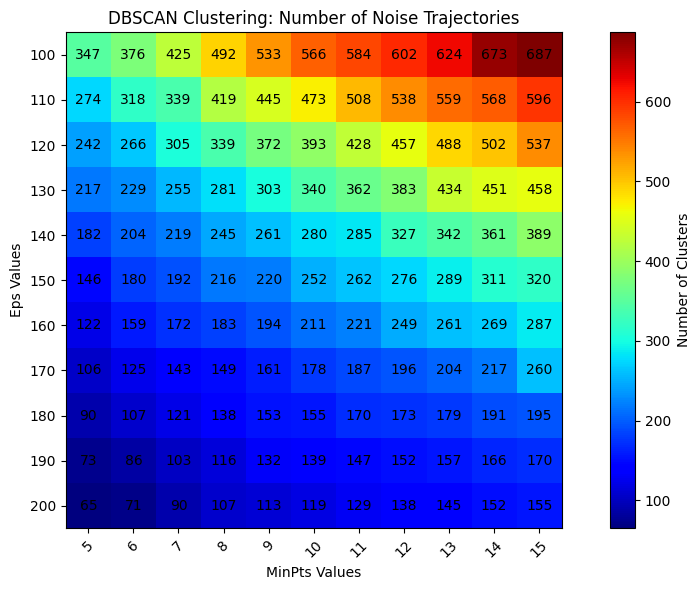

In [ ]:
y_ticks = eps_values
x_ticks = min_samples_values

# Create a heatmap of cluster numbers
plt.figure(figsize=(10, 6))
plt.imshow(noise,cmap=plt.cm.jet)
plt.colorbar(label='Number of Clusters')
plt.ylabel('Eps Values')
plt.xlabel('MinPts Values')
plt.xticks(np.arange(len(x_ticks)), x_ticks, rotation=45)
plt.yticks(np.arange(len(y_ticks)), y_ticks)
plt.title('DBSCAN Clustering: Number of Noise Trajectories')

for i in range(len(y_ticks)):
    for j in range(len(x_ticks)):
        plt.text(j, i, str(noise[i, j]), ha='center', va='center', color='black')

#plt.grid(False)
plt.tight_layout()
plt.show()

15


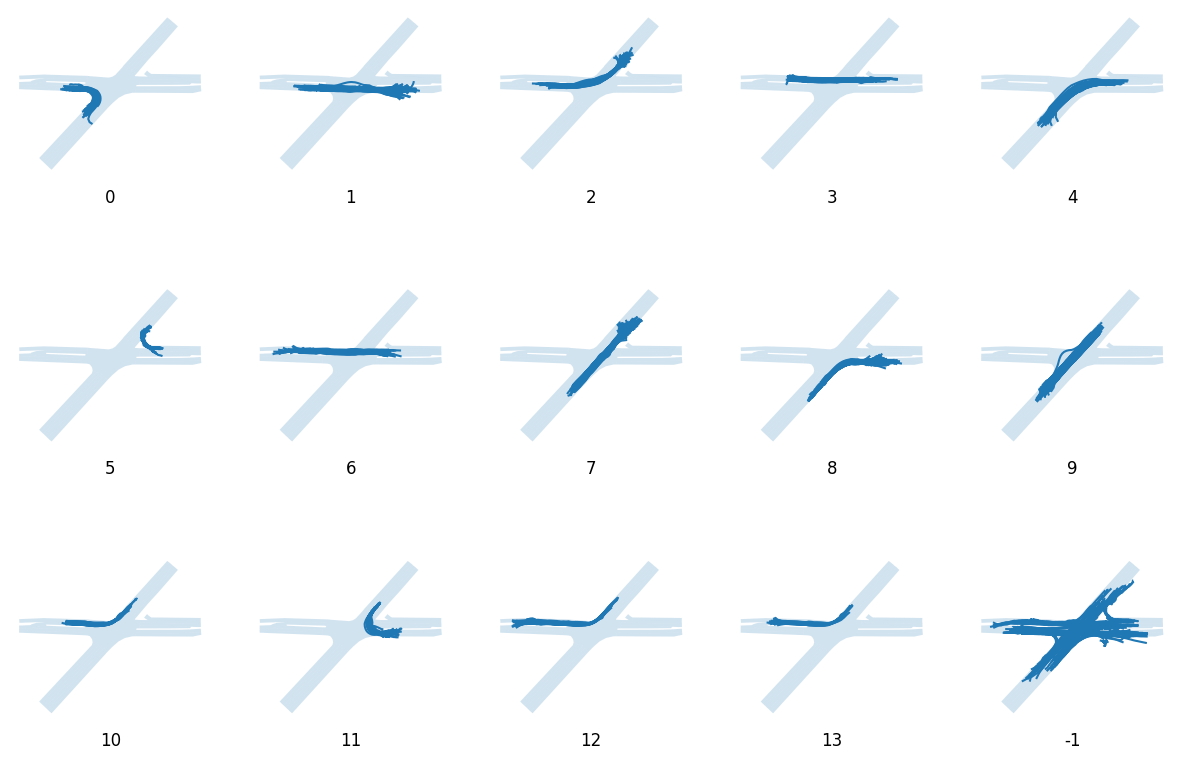

In [ ]:
eps = 180
samples = 10
mdl = DBSCAN(eps=eps,min_samples=samples)
cluster_lst = mdl.fit_predict(D)
print(len(set(cluster_lst)))


gdf['dbscan'] = cluster_lst

fig, axes = plt.subplots(3,5,figsize=(15,10))
for i, group in gdf.groupby('dbscan'):
    ax=axes.flatten()[i]
    zones.plot(alpha=.2,ax=ax)
    group.plot(ax=ax)
    ax.axis('off')
    ax.text(0.5, -0.15, f'{i}', fontsize=12, color='black', ha='center', transform=ax.transAxes)


In [ ]:
gdf[gdf['dbscan']==-1].shape

(155, 4)